# Rugby Vision

Ce notebook a pour objectif de réaliser la détection du ballon et du terrain afin de visualiser, de manière graphique, si la pénalité a été transformée ou non. Il s'appuie sur plusieurs étapes :

1) Traitement vidéo
2) Détection du ballon : position initiale, et détermination de son passage (oui/non) entre les poteaux
3) Détection du terrain et homographie
4) Visualisation

#### Imports

In [24]:
import cv2
import os
from tkinter import Tk, messagebox
import re
import numpy as np


## Traitement vidéo

### Entrez une vidéo

In [25]:
video_path="4.mp4"

### Accélération de la vidéo

In [26]:
def accelerate_video(video_path, original_video_speed, factor=4):
    # Ouvrir la vidéo d'entrée
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erreur : Impossible de lire la vidéo.")
        return

    # Obtenir les propriétés de la vidéo
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Nouveau FPS (multiplié par le facteur d'accélération)
    new_fps = fps * factor

    # Configurer l'écrivain de vidéo pour la sortie avec le nouveau FPS
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Format de sortie
    out = cv2.VideoWriter(original_video_speed, fourcc, new_fps, (width, height))

    # Lire et écrire chaque frame à une vitesse plus rapide
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)

    # Libérer les ressources
    cap.release()
    out.release()
    print(f"Vidéo accélérée sauvegardée sous : {original_video_speed}")

base_name, ext = os.path.splitext(video_path)
original_video_speed = f"{base_name}_speed{ext}"
accelerate_video(video_path, original_video_speed, factor=4)


Vidéo accélérée sauvegardée sous : 4_speed.mp4


### Extraction des pénalités de la vidéo

Cela enregistrera les frames où les clics ont été effectués dans un fichier texte.

In [27]:
def record_clicks(input_video, output_file):
    # Ouvrir la vidéo
    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print("Erreur : Impossible de lire la vidéo.")
        return

    clicks = []
    def click_event(event, x, y, flags, param):
        # Si l'utilisateur clique sur la vidéo
        if event == cv2.EVENT_LBUTTONDOWN:
            time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Temps en secondes
            frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))  # Numéro de la frame
            clicks.append(f"{time:.2f} seconds, frame {frame}")
            print(f"Clic enregistré à {time:.2f} secondes, frame {frame}")

    # Obtenir les dimensions de la vidéo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Afficher la vidéo et attendre les clics
    cv2.namedWindow("Accelere", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Accelere", width, height)
    cv2.setMouseCallback("Accelere", click_event)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow("Accelere", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Appuyer sur 'q' pour quitter
            break

    # Sauvegarder les moments des clics dans un fichier texte
    with open(output_file, 'w') as f:
        for click in clicks:
            f.write(click + "\n")

    # Libérer les ressources
    cap.release()
    cv2.destroyAllWindows()
    print(f"Moments des clics sauvegardés dans : {output_file}")

# Utilisation du code
input_video = original_video_speed  # Vidéo accélérée
output_file = "click_times.txt"  # Fichier pour sauvegarder les clics
record_clicks(input_video, output_file)


Clic enregistré à 9.86 secondes, frame 1184
Clic enregistré à 10.48 secondes, frame 1259
Clic enregistré à 23.66 secondes, frame 2840
Clic enregistré à 28.55 secondes, frame 3427
Moments des clics sauvegardés dans : click_times.txt


### Création d'une nouvelle vidéo avec seulement les moment où les penalites sont tirées

Cette étape permet de réduire la vidéo en conservant uniquement les moments d'intérêt, c'est-à-dire les instants où les pénalités sont tirées.
Pour cette étape nous recupérons les moments où l'utilisateur a cliqué (stockés dans le fichier texte) et nous récupérons la seconde d'avant et la seconde d'après

### Reconstituer la video avec seulement les videos 

In [28]:
def extract_segments(input_video, click_file, final_accelerate_video, padding=1):
    # Ouvrir la vidéo d'entrée
    cap = cv2.VideoCapture(input_video)
    if not cap.isOpened():
        print("Erreur : Impossible de lire la vidéo.")
        return

    # Obtenir les propriétés de la vidéo d'entrée
    fps_input = int(cap.get(cv2.CAP_PROP_FPS))  # FPS d'origine
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    # Ouvrir le fichier de sortie avec le FPS original
    out = cv2.VideoWriter(final_accelerate_video, fourcc, fps_input, (width, height))

    # Lire le fichier de clics
    with open(click_file, 'r') as f:
        lines = f.readlines()

    segments = []
    for line in lines:
        time, frame = line.strip().split(', frame ')
        frame_number = int(frame)
        
        # Calcul des frames avant et après le clic, en utilisant la vidéo d'origine
        start_frame = max(0, frame_number - padding * fps_input)  # Prendre 2 sec avant
        end_frame = min(frame_count, frame_number + padding * fps_input)  # Prendre 2 sec après
        segments.append((start_frame, end_frame))

    # Extraire et écrire chaque segment dans la vidéo de sortie
    for start_frame, end_frame in segments:
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        for frame_num in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)

    # Libérer les ressources
    cap.release()
    out.release()
    print(f"Vidéo avec les segments des clics sauvegardée sous : {final_accelerate_video}")

# Utilisation du code
input_video = original_video_speed  # Vidéo d'entrée
click_file = "click_times.txt"  # Fichier des clics
final_accelerate_video = "final_video_accelerate.mp4"  # Vidéo finale
extract_segments(input_video, click_file, final_accelerate_video, padding=1)



Vidéo avec les segments des clics sauvegardée sous : final_video_accelerate.mp4


### Décélération de la vidéo finale

La vidéo que nous avons recréé juste au dessus est toujours accélérée nous devons dpnc la ralentir pour retrouver la vitesse initiale (nous divisons la vitesse par 4 comme nous l'avons initialement accélérée par 4)

In [29]:
cap = cv2.VideoCapture('final_video_accelerate.mp4')

fps = cap.get(cv2.CAP_PROP_FPS) 
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  

out = cv2.VideoWriter('final_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps / 4, (width, height))

frame_index = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    out.write(frame)
    frame_index += 1
    if frame_index % 4 != 0: 
        continue

cap.release()
out.release()
cv2.destroyAllWindows()


### Création des segments

Nous découpons maintenant la vidéo finale en segment. Chaque segement représente une pénalité

In [30]:
def create_segments(video_path, segment_duration=8, segment_folder="segments"):
    """
    Découpe une vidéo en segments d'une durée spécifiée (en secondes).
    :param video_path: Chemin de la vidéo à découper.
    :param segment_duration: Durée de chaque segment en secondes.
    :param segment_folder: Dossier où enregistrer les segments découpés.
    :return: Liste des chemins des segments créés.
    """
    os.makedirs(segment_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Erreur: Impossible de lire la vidéo.")
        return []

    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Récupérer les FPS de la vidéo
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Récupérer le nombre total de frames
    frames_per_segment = fps * segment_duration  # Durée du segment en nombre de frames
    segment_paths = []

    # Découper la vidéo en segments
    for i in range(0, total_frames, frames_per_segment):
        segment_path = os.path.join(segment_folder, f"segment_{i // frames_per_segment + 1}.mp4")
        segment_paths.append(segment_path)

        # Définir le writer vidéo pour ce segment
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(segment_path, fourcc, fps, 
                              (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

        cap.set(cv2.CAP_PROP_POS_FRAMES, i)  # Définir la position de départ dans la vidéo
        for _ in range(frames_per_segment):
            ret, frame = cap.read()
            if not ret:
                break
            out.write(frame)

        out.release()

    cap.release()
    print(f"Découpage terminé. {len(segment_paths)} segments créés.")
    return segment_paths

# Exemple d'utilisation :
video_path = 'final_video.mp4'  # Remplacez ce chemin par le chemin de votre vidéo
create_segments(video_path, segment_duration=8)  # Découper la vidéo en segments de 8 secondes


Découpage terminé. 4 segments créés.


['segments\\segment_1.mp4',
 'segments\\segment_2.mp4',
 'segments\\segment_3.mp4',
 'segments\\segment_4.mp4']

### Analyse des segements

Nous analysons chaque segment pour avoir le tracking du ballon grace a une technique de différence de pixel entre 2 frames. Nous avons aussi appliqué un filtre qui nous permet de seulement garder l'élément en mouvement le plus haut de l'image

In [31]:
# Fonction pour analyser chaque vidéo
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Erreur: Impossible de lire la vidéo {video_path}.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # Largeur de la vidéo
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # Hauteur de la vidéo
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    print(f"Dimensions de la vidéo {video_path} : {width}x{height}, FPS : {fps}")

    # Initialisation du VideoWriter pour sauvegarder la vidéo annotée
    fourcc = cv2.VideoWriter_fourcc(*'H264')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    prev_frame = None

    while True:
        ret, frame = cap.read()
        if not ret:
            print(f"Fin de la vidéo {video_path} ou erreur de lecture.")
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev_frame is not None:
            diff = cv2.absdiff(prev_frame, gray_frame)
            _, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)

            # Trouver les contours des zones où il y a des différences
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            annotated_frame = frame.copy()
            highest_box = None
            min_y = float('inf')

            # Parcourir les contours et déterminer la boîte avec le plus petit 'y'
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                if y < min_y:
                    min_y = y
                    highest_box = (x, y, w, h)

            # Si une boîte a été trouvée, dessiner la boîte la plus haute
            if highest_box is not None:
                x, y, w, h = highest_box
                cv2.rectangle(annotated_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(annotated_frame, f"x:{x}, y:{y}", (x, y - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                print(f"Coordonnées de la boîte la plus haute : x={x}, y={y}, w={w}, h={h}")

            out.write(annotated_frame)

        prev_frame = gray_frame
        frame_count += 1

    cap.release()
    out.release()

    print(f"Vidéo annotée sauvegardée avec succès : {output_path}")

# Analyser toutes les vidéos dans le dossier 'segments/'
segment_folder = 'segments/'
segment_files = [f for f in os.listdir(segment_folder) if f.endswith('.mp4')]

# Créer un dossier pour les vidéos annotées
os.makedirs("segments_annotated", exist_ok=True)

# Traiter chaque vidéo dans le dossier 'segments/'
for segment_file in segment_files:
    video_path = os.path.join(segment_folder, segment_file)
    output_path = os.path.join("segments_annotated", f"annotated_{segment_file}")
    
    # Analyser et annoter la vidéo
    process_video(video_path, output_path)

cv2.destroyAllWindows()
print("Traitement terminé pour toutes les vidéos.")


Dimensions de la vidéo segments/segment_1.mp4 : 1920x1080, FPS : 30
Coordonnées de la boîte la plus haute : x=1191, y=191, w=1, h=1
Coordonnées de la boîte la plus haute : x=53, y=384, w=1, h=1
Coordonnées de la boîte la plus haute : x=39, y=378, w=1, h=4
Coordonnées de la boîte la plus haute : x=53, y=384, w=1, h=2
Coordonnées de la boîte la plus haute : x=112, y=375, w=1, h=1
Coordonnées de la boîte la plus haute : x=1517, y=287, w=2, h=1
Coordonnées de la boîte la plus haute : x=108, y=376, w=1, h=1
Coordonnées de la boîte la plus haute : x=39, y=379, w=1, h=3
Coordonnées de la boîte la plus haute : x=120, y=375, w=1, h=2
Coordonnées de la boîte la plus haute : x=108, y=383, w=1, h=1
Coordonnées de la boîte la plus haute : x=480, y=127, w=1, h=1
Coordonnées de la boîte la plus haute : x=1878, y=392, w=1, h=1
Coordonnées de la boîte la plus haute : x=113, y=390, w=1, h=1
Coordonnées de la boîte la plus haute : x=38, y=382, w=3, h=3
Coordonnées de la boîte la plus haute : x=67, y=431,

### Position initale et réussite de la pénalités

Les segments vont se lancer un par un. L'utilisateur doit ici réaliser deux actions. L'utilisateur doit tout d'abord cliqué sur la position de la balle pendant la vidéo. A la fin de chaque segment un pop up va apparaitre et demander a lu'ilisateur si la balle est rentrée. Tous les informations recoltées dans les segments (nom de la vidéo, frame du click, position de la balle, et la réussite de la pénalité) sont écrites dans un fichier texte "penalty_positions.txt"

In [32]:
# Variables globales
penalty_positions = []  # Liste pour stocker les positions et frames des pénalités
frame_index = 0  # Indice de la frame actuelle
global frame  # Déclarer `frame` comme variable globale pour pouvoir la modifier dans `click_event`

frame = None  # Variable pour stocker la frame actuelle
lines = []

# Fonction de gestion des clics
def click_event(event, x, y, flags, param):
    """
    Fonction pour gérer les clics de souris.
    """
    global penalty_positions, frame_index, frame
    if event == cv2.EVENT_LBUTTONDOWN:  # Clic gauche
        penalty_positions.append((frame_index, (x, y)))  # Ajouter la frame et la position du clic
        print(f"Pénalité détectée à la frame {frame_index}, position : x={x}, y={y}")
        # Dessiner un point rouge sur la frame actuelle
        cv2.circle(frame, (x, y), 5, (0, 0, 255), -1)  # Dessiner un point rouge

# Charger les segments vidéo
segment_folder = "segments"
segment_files = sorted([f for f in os.listdir(segment_folder) if f.endswith('.mp4')])

# Lire ou créer le fichier penalty_positions.txt
positions_file = 'penalty_positions.txt'
if not os.path.exists(positions_file):
    # Si le fichier n'existe pas, on le crée
    open(positions_file, 'w').close()

# Fonction pour poser la question et obtenir la réponse
def ask_question(segment_index):
    root = Tk()
    root.withdraw()  # Cacher la fenêtre principale de Tkinter

    response = messagebox.askquestion(
        "Question",
        f"La balle est-elle rentrée pour le segment {segment_index + 1} ?",
        icon='question'
    )
    root.destroy()  # Détruire la fenêtre après avoir obtenu la réponse
    return "Oui" if response == "yes" else "Non"

# Processus pour chaque segment
for index, segment_file in enumerate(segment_files):
    # Charger le segment vidéo
    segment_path = os.path.join(segment_folder, segment_file)
    cap = cv2.VideoCapture(segment_path)

    if not cap.isOpened():
        print(f"Erreur: Impossible de lire le segment {segment_file}")
        continue

    # Obtenir les dimensions et le FPS de la vidéo
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    delay = int(700 / fps)  # Délai en millisecondes pour chaque frame

    # Redimensionner la fenêtre pour correspondre à la taille de la vidéo
    cv2.namedWindow("Segment", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Segment", width, height)

    # Lire et afficher le segment à la vitesse correcte
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_index = int(cap.get(cv2.CAP_PROP_POS_FRAMES))  # Récupérer l'index de la frame actuelle
        cv2.imshow("Segment", frame)

        cv2.setMouseCallback("Segment", click_event)  # Associer la gestion des clics

        if cv2.waitKey(delay) & 0xFF == ord('q'):  # Respecter la vitesse de la vidéo
            break

    cap.release()

    # Demander la réponse après avoir visionné la vidéo
    reponse = ask_question(index)

    # Ajouter les positions de pénalités et les réponses à la liste
    for frame_num, position in penalty_positions:
        lines.append(f"Video: {segment_file}, Frame: {frame_num}, Position: {position}, Rentree : {reponse}\n")

    # Réinitialiser la liste des positions après chaque segment
    penalty_positions.clear()

    # Fermer toutes les fenêtres après avoir visionné chaque segment
    cv2.destroyAllWindows()

# Écrire les lignes mises à jour dans le fichier
with open(positions_file, 'w') as file:
    file.writelines(lines)

print("Mises à jour enregistrées dans penalty_positions.txt.")


Pénalité détectée à la frame 84, position : x=852, y=537
Pénalité détectée à la frame 85, position : x=1328, y=557
Pénalité détectée à la frame 109, position : x=1610, y=513
Pénalité détectée à la frame 50, position : x=1325, y=537
Mises à jour enregistrées dans penalty_positions.txt.


### Extraction d'une frame pour placer les keypoints

Ici nous prenons la frame quand l'utilisateur a cliqué sur la position initiale pour l'analyser et placer les keypoints grace aux modeles

In [33]:
# Dossier contenant les segments vidéo
video_folder = "segments"
frame_output_folder = "frames_output"

# Créer le dossier de sortie pour les frames extraites
os.makedirs(frame_output_folder, exist_ok=True)

# Fonction pour extraire une frame spécifique d'une vidéo et la sauvegarder
def extract_and_save_frame(video_path, frame_number, output_folder):
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)  # Les frames commencent à 0
    success, current_frame = video.read()
    if success:
        frame_output_path = os.path.join(output_folder, f"frame_{frame_number}_{os.path.basename(video_path).replace('.mp4', '')}.png")
        cv2.imwrite(frame_output_path, current_frame)
        print(f"Frame numéro {frame_number} extraite et sauvegardée sous {frame_output_path}")
    else:
        print(f"Erreur : impossible d'extraire la frame numéro {frame_number}.")
    video.release()

# Lecture et analyse du fichier texte
input_path = 'penalty_positions.txt'
with open(input_path, 'r') as file:
    lines = file.readlines()

pattern = r"Video: (.*?), Frame: (\d+), Position: \((\d+), (\d+)\), Rentree : (Oui|Non)"
penalty_positions = []
for line in lines:
    match = re.search(pattern, line)
    if match:
        video_name = match.group(1)
        frame_number = int(match.group(2))
        position = (int(match.group(3)), int(match.group(4)))
        video_path = os.path.join(video_folder, video_name)
        penalty_positions.append((video_path, frame_number, position))

# Extraction et sauvegarde des frames
for video_path, frame_number, position in penalty_positions:
    extract_and_save_frame(video_path, frame_number, frame_output_folder)


Frame numéro 84 extraite et sauvegardée sous frames_output\frame_84_segment_1.png
Frame numéro 85 extraite et sauvegardée sous frames_output\frame_85_segment_2.png
Frame numéro 109 extraite et sauvegardée sous frames_output\frame_109_segment_3.png
Frame numéro 50 extraite et sauvegardée sous frames_output\frame_50_segment_4.png


## Détection keypoints terrain et poteaux

### Chargement des modèles de détection et imports

In [34]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Charger les modèles entraînés
model_poteaux = YOLO("modèle_poteau_50.pt")
model_terrain = YOLO("model_terrain_60.pt")

On applique les deux modèles sur les images de frames_output.

In [47]:
# Chemin du dossier contenant les images
image_folder = "frames_output"

# Récupérer tous les fichiers image dans le dossier
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Liste pour stocker toutes les coordonnées transformées
all_transformed_coords = []

# Traitement de chaque image
for image_path in image_paths:

    print(image_path)

    # Expression régulière pour capturer les numéros après "frame_" et "segment_" dans le nom du fichier
    match = re.search(r"frame_(\d+)_segment_(\d+)", image_path)

    if match:
        frame_number = int(match.group(1))  # Récupère le numéro de la frame
        video_number = int(match.group(2))  # Récupère le numéro de la vidéo
        print("Numéro de la frame :", frame_number)
        print("Numéro de la vidéo :", video_number)


    else:
        print("Aucun numéro de frame trouvé dans le nom du fichier.")
        # Charger l'image
    image = cv2.imread(image_path)

    # Exécuter les modèles sur l'image
    results_poteaux = model_poteaux(image)
    results_terrain = model_terrain(image)

    # Seuil de confiance minimum
    confidence_threshold = 0.7

    # Récupérer les keypoints validés du modèle "Poteaux"
    filtered_keypoints_poteaux = []
    for instance_idx, keypoints in enumerate(results_poteaux[0].keypoints.data):
        for keypoint_idx, (x, y, conf) in enumerate(keypoints):
            if conf.item() >= confidence_threshold:
                if keypoint_idx + 1 == 5: 
                    filtered_keypoints_poteaux.append({
                        "keypoint": "p_droit",
                        "x": x.item(),
                        "y": y.item()
                    })
                elif keypoint_idx + 1 == 6: 
                    filtered_keypoints_poteaux.append({
                        "keypoint": "p_gauche",
                        "x": x.item(),
                        "y": y.item()
                    })

    # Récupérer et renommer les keypoints validés du modèle "Terrain"
    filtered_keypoints_terrain = []
    for keypoint_idx, keypoints in enumerate(results_terrain[0].keypoints.data):
        for kp_idx, (x, y, conf) in enumerate(keypoints):
            if conf.item() >= confidence_threshold:
                if kp_idx + 1 in [5]:
                    keypoint_name = ""
                elif kp_idx + 1 in [6]: 
                    keypoint_name = "15_32"
                elif kp_idx + 1 in [7]: 
                    keypoint_name = "55_32"
                elif kp_idx + 1 in [8]: 
                    keypoint_name = "65_32"
                elif kp_idx + 1 in [9]: 
                    keypoint_name = "15_50"
                elif kp_idx + 1 in [10]:  
                    keypoint_name = "55_50"
                elif kp_idx + 1 in [11]:
                    keypoint_name = "65_50"
                elif kp_idx + 1 in [12]:
                    keypoint_name = "5_50"
                else:
                    keypoint_name = f"T{kp_idx + 1}_autre"

                filtered_keypoints_terrain.append({
                    "keypoint_name": keypoint_name,
                    "x": x.item(),
                    "y": y.item()
                })

    # Charger les coordonnées depuis le fichier .txt
    coordinates = []

    with open('penalty_positions.txt', 'r') as file:
        for line in file:
            print(line)
            # Vérifier si la ligne contient le numéro de la vidéo et de la frame en cours
            if f"Video: segment_{video_number}.mp4, Frame: {frame_number}" in line:  # Cherche la ligne contenant "Video: segment_X.mp4, Frame: Y"
                # Extraire les coordonnées après "Position:"
                print(video_number)
                print(frame_number)
                if "Position" in line:
                    parts = line.strip().split("Position:")[1].strip()
                    coordinates_str = parts.split(")")[0]  # Enlever tout après la parenthèse fermante
                    x, y = map(int, coordinates_str.strip("()").split(", "))  # Extraire les coordonnées
                    coordinates.append([x, y])
                    print("coordinates", coordinates)



    # Vérification des coordonnées
    if not coordinates:
        print(f"Erreur : aucune coordonnée trouvée dans le fichier .txt pour {image_path}.")
        continue

    # Extraire les points des poteaux et du terrain
    p_droit = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_poteaux if d["keypoint"] == "p_droit"), (0, 0))
    p_gauche = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_poteaux if d["keypoint"] == "p_gauche"), (0, 0))
    p_15_32 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "15_32"), (0, 0))
    p_55_32 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "55_32"), (0, 0))
    p_65_32 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "65_32"), (0, 0))
    p_15_50 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "15_50"), (0, 0))
    p_55_50 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "55_50"), (0, 0))
    p_65_50 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "65_50"), (0, 0))
    p_5_50 = next(((int(d["x"]), int(d["y"])) for d in filtered_keypoints_terrain if d["keypoint_name"] == "5_50"), (0, 0))

    # Déterminer les points d'image et réels
    if p_65_50 == (0, 0):
        image_points = np.array([p_5_50, p_15_50, p_15_32, p_gauche], dtype=np.float32)
        real_points_test = np.array([[5, 50], [15, 50], [15, 32], [32.2, 10]], dtype=np.float32)
    if p_5_50 == (0, 0):
        image_points = np.array([p_55_50, p_65_50, p_65_32, p_55_32], dtype=np.float32)
        real_points_test = np.array([[55, 50], [65, 50], [65, 32], [55, 32]], dtype=np.float32)
    if p_5_50 == (0, 0) and p_65_32 == (0,0):
        image_points = np.array([p_15_32, p_15_50, p_55_50, p_55_32], dtype=np.float32)
        real_points_test = np.array([[15, 32], [15, 50], [55, 50], [55, 32]], dtype=np.float32)

    # Calcul de la matrice d'homographie
    H, _ = cv2.findHomography(image_points, real_points_test)

    # Convertir les coordonnées des joueurs
    player_coords = np.array(coordinates, dtype=np.float32)
    player_coords_transformed = cv2.perspectiveTransform(np.array([player_coords]), H)

    # Extraire les coordonnées transformées
    transformed_coords = player_coords_transformed[0]

    all_transformed_coords.append(transformed_coords)

    # Affichage des coordonnées transformées pour l'image
    print(f"Coordonnées des ballons transformées pour {image_path} (en mètres) :")
    for coord in transformed_coords:
        print(f"Joueur : {coord}")

# Afficher toutes les coordonnées transformées
print("Toutes les coordonnées transformées (en mètres) :")
for coords in all_transformed_coords:
    for coord in coords:
        print(f"Joueur : {coord}")

print(all_transformed_coords)        

frames_output\frame_105_segment_3.png
Numéro de la frame : 105
Numéro de la vidéo : 3

0: 384x640 1 poteaux, 519.6ms
Speed: 2.5ms preprocess, 519.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Terrain, 520.7ms
Speed: 2.7ms preprocess, 520.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Video: segment_1.mp4, Frame: 84, Position: (852, 537), Rentree : Oui

Video: segment_2.mp4, Frame: 85, Position: (1328, 557), Rentree : Non

Video: segment_3.mp4, Frame: 109, Position: (1610, 513), Rentree : Non

Video: segment_4.mp4, Frame: 50, Position: (1325, 537), Rentree : Non

Erreur : aucune coordonnée trouvée dans le fichier .txt pour frames_output\frame_105_segment_3.png.
frames_output\frame_109_segment_3.png
Numéro de la frame : 109
Numéro de la vidéo : 3

0: 384x640 1 poteaux, 476.9ms
Speed: 2.0ms preprocess, 476.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Terrain, 494.3ms
Speed: 2.9ms preprocess, 4

In [48]:
# Vérification de la structure de all_transformed_coords
print("Structure de all_transformed_coords :", all_transformed_coords)


Structure de all_transformed_coords : [array([[         66,      35.531]], dtype=float32), array([[     55.584,      34.589]], dtype=float32), array([[     41.257,      38.215]], dtype=float32), array([[      54.62,      32.231]], dtype=float32)]


## Visualisation

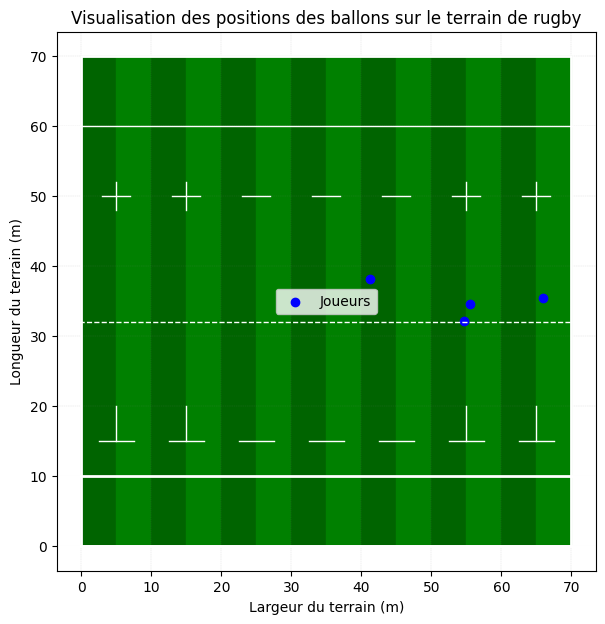

In [50]:

# Création du terrain de rugby
plt.figure(figsize=(12, 7))
plt.title("Visualisation des positions des ballons sur le terrain de rugby")

# Dimensions du terrain en mètres
terrain_width = 70
terrain_length = 70
terrain_playable_length = 60

# Tracer les bandes alternées verticales (vert clair et vert foncé)
for i in range(0, terrain_width, 5):
    color = 'darkgreen' if (i // 5) % 2 == 0 else 'green'
    plt.fill_betweenx([0, terrain_length], i, i + 5, color=color)

# Tracer le contour du terrain
plt.plot([0, terrain_width, terrain_width, 0, 0],
         [0, 0, terrain_length, terrain_length, 0], color='white', linewidth=2)

# Tracer les lignes principales
plt.axhline(0, color='white', linestyle='-', linewidth=2)
plt.axhline(10, color='white', linestyle='-', linewidth=2)
plt.axhline(22 + 10, color='white', linestyle='--', linewidth=1)
plt.axhline(50 + 10, color='white', linestyle='-', linewidth=1)

# Tracer les croix et les lignes de terrain
cross_x_positions = [5, 15, terrain_width - 15, terrain_width - 5]
for x in cross_x_positions:
    plt.plot([x - 2.5, x + 2.5], [15, 15], color='white', linewidth=1)
    plt.plot([x, x], [15, 20], color='white', linewidth=1)
    plt.plot([x - 2, x + 2], [terrain_length - 20, terrain_length - 20], color='white', linewidth=1)
    plt.plot([x, x], [terrain_length - 22, terrain_length - 18], color='white', linewidth=1)

line_x_positions = [25, 35, 45]
for x in line_x_positions:
    plt.plot([x - 2.5, x + 2.5], [15, 15], color='white', linewidth=1)
    plt.plot([x - 2, x + 2], [terrain_length - 20, terrain_length - 20], color='white', linewidth=1)

# Extraction des coordonnées x et y de all_transformed_coords
x_coords = [coord[0][0] for coord in all_transformed_coords]  # Liste des coordonnées x
y_coords = [coord[0][1] for coord in all_transformed_coords]  # Liste des coordonnées y

# Tracer les positions des joueurs ou des points
plt.scatter(x_coords, y_coords, color='blue', label='Joueurs')

# Ajouter des labels pour les axes
plt.xlabel("Largeur du terrain (m)")
plt.ylabel("Longueur du terrain (m)")

# Ajustement du rapport d'aspect et grille discrète
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.3)

# Afficher la légende et la visualisation
plt.legend()
plt.show()


## Environmental Impact

### 1. Find the CPU consumption with Powershell and powercfg /energy

In [37]:
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

import environmental_impact

### 2. Take the equivalent in kgCO2

#### Ball Detection :

In [38]:
consumption_kwh = 0.0003265
environmental_impact.calculate_impact(consumption_kwh=consumption_kwh)

URL: https://api.electricitymap.org/v3/carbon-intensity/latest
Headers: {'auth-token': 'mkghuvLIc24M7'}
Data fetched successfully!
Response JSON: {'zone': 'FR', 'carbonIntensity': 63, 'datetime': '2025-01-14T16:00:00.000Z', 'updatedAt': '2025-01-14T15:44:02.662Z', 'createdAt': '2025-01-11T16:42:40.066Z', 'emissionFactorType': 'lifecycle', 'isEstimated': True, 'estimationMethod': 'TIME_SLICER_AVERAGE'}
Total CO2 emissions for 0.0003265 kWh: 2.05695e-05 kgCO2eq


#### Field detection :

In [39]:
consumption_kwh = 0.000383
environmental_impact.calculate_impact(consumption_kwh=consumption_kwh)

URL: https://api.electricitymap.org/v3/carbon-intensity/latest
Headers: {'auth-token': 'mkghuvLIc24M7'}
Data fetched successfully!
Response JSON: {'zone': 'FR', 'carbonIntensity': 63, 'datetime': '2025-01-14T16:00:00.000Z', 'updatedAt': '2025-01-14T15:44:02.662Z', 'createdAt': '2025-01-11T16:42:40.066Z', 'emissionFactorType': 'lifecycle', 'isEstimated': True, 'estimationMethod': 'TIME_SLICER_AVERAGE'}
Total CO2 emissions for 0.000383 kWh: 2.4129e-05 kgCO2eq
